# "Concevez une application au service de la santé publique"
_Analysis Notebook_

In [1]:
from google.colab import files, drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
# May need to reboot the environment
!pip install -r "My Drive/--DATA SCIENCE/PROJET3/requirements.txt"
!pip install ppscore
!pip install simplejson
!pip install mlxtend
!pip install gTTS

In [3]:
import os
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import simplejson as json
import missingno as msno
import ppscore as pps

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans

plt.rcParams['figure.facecolor']='w'

# To play audio text-to-speech during execution
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

# Get list of dtype from json
f = open('My Drive/--DATA SCIENCE/PROJET3/d_types.json', 'r')
d_types = json.loads(f.read().replace('datetime64', 'object'))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Import cleaned dataset
df_init = pd.read_csv('My Drive/--DATA SCIENCE/PROJET3/OFF_Cleaned.csv',
                 index_col='Unnamed: 0', dtype=d_types,
                 low_memory=False, encoding ='utf-8')
df_init['created_datetime'] = pd.to_datetime(df_init['created_datetime'])

In [5]:
for i, c in enumerate(df_init.columns):
    print('\n'+c if i % 6 == 0 else c, end=' | ')


code | code_val | categories_main | categories_tuple | url | main_category | 
quantity_unit | quantity_num | serving_quantity | quantity_type | labels_main | labels_tuple | 
pnns2 | pnns1 | creator | created_datetime | product_name | countries_main | 
brands_main | packaging_main | packaging_tuple | brands_tuple | allergens_main | allergens_tuple | 
countries_tuple | ingredients_text | additives_main | traces_main | traces_tuple | additives_tuple | 
additives_n | nutriscore | nutrigrade | nova_group | fat_100g | saturated_fat_100g | 
carbohydrates_100g | sugars_100g | fiber_100g | proteins_100g | salt_100g | sodium_100g | 
energy_from_fat_kj_100g | energy_kj_100g | ing_from_palm_oil_n | 

## 0 Preliminaries

### 0.1 Overview of missing data

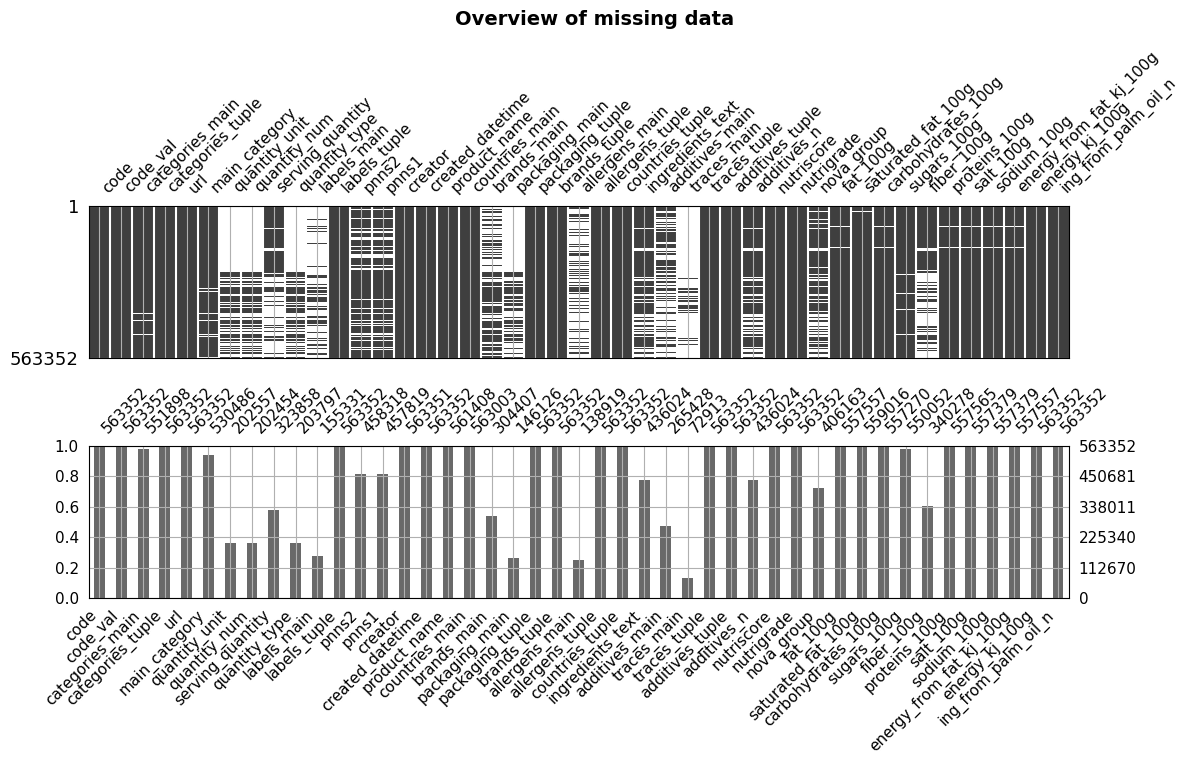

In [6]:
# Displaying number of missing values
cols = df_init.columns
with plt.style.context('default'):
    fig, axs = plt.subplots(2,1)
    msno.matrix(df_init[cols] , sparkline=False,
                fontsize=11, ax=axs[0])
    msno.bar(df_init[cols], ax=axs[1], fontsize=11)
   
fig.set_size_inches(12,8)
[ax.grid() for ax in axs.flatten()];
[sns.despine(ax=ax, right=False, left=False,top=False, bottom=False)\
                                    for ax in axs.flatten()];
plt.subplots_adjust(hspace=0.3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Overview of missing data', fontweight='bold', fontsize=14)
plt.savefig('/content/missing_vals.png', dpi=400);
plt.show()

We can split cleaned data in 4 categories, each of them being either quantitative (col_X_Q) or categorical (col_X_C).

NB: Among categorical data, some are lists (col_X_C_) that should be treated separately. We could for example duplicate products (1 per item of the list).

1. [cols_1]: almost totally filled (>90%), can be infered (median or more frequent)
2. [cols_2]: missing data <50%, can be infered (model)
3. [cols_3]: missing data can be infered with 0 (optional data)
4. [cols_4]: missing data, cannot be infered, but possible to drop nan and study the remainers as a subset




In [7]:
speak('overview of missing data: done')

### 0.2 Imputation

In [0]:
# Splitting columns in categories
info_cols =  ['code','code_val','url','creator','created_datetime',
              'product_name', 'ingredients_text']
cols_1_Q = ['nutriscore','fat_100g','carbohydrates_100g','proteins_100g',
            'salt_100g','saturated_fat_100g', 'sugars_100g', 'sodium_100g',
            'energy_kj_100g','energy_from_fat_kj_100g']
cols_1_C = ['nutrigrade', 'countries_main', 'categories_main']
cols_1_C_ = ['countries_tuple', 'categories_tuple']

cols_2_Q = ['fiber_100g']
cols_2_C = ['nova_group', 'pnns1', 'pnns2', 'main_category']
cols_2_C_ = []

cols_3_Q = ['ing_from_palm_oil_n','additives_n']
cols_3_C = ['additives_main','labels_main','allergens_main', 'traces_main']
cols_3_C_ = ['additives_tuple','labels_tuple','allergens_tuple', 'traces_tuple']

cols_4_Q = ['quantity_num', 'serving_quantity']
cols_4_C = ['brands_main','packaging_main', 'quantity_type','quantity_unit']
cols_4_C_ = ['brands_tuple','packaging_tuple']

In [0]:
df = df_init.copy('deep')

#### **Case 1**: almost totally filled (>90%), can be infered (median or more frequent)

In [0]:
# Case1 : imputation with most frequent or median
for c in cols_1_Q:
    df[c] = df[c].fillna(df[c].median())
for c in cols_1_C+cols_1_C_:
    df[c] = df[c].fillna(df[c].mode()[0])

In [11]:
speak('imputation case 1: done')

#### **Case 2**: missing data <50%, can be infered (model)

NB: We'll suppose here that data is missing at random!!!

cols_2_Q : 'fiber_100g'

In [0]:
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.dummy import DummyRegressor

In [0]:
## Data Processing
# most correlated features (see pearson_corr matrix below)
vars_knn = ['carbohydrates_100g', 'nutriscore', 'energy_kj_100g']
# all data with no nan
df_knn = df[vars_knn+['fiber_100g']].dropna(how='any')
data = df_knn.values
X_sc = StandardScaler().fit_transform(data[:,:-1])
y = data[:,-1]
X_sc_tr, X_sc_te, y_tr, y_te = train_test_split(X_sc, y, test_size=0.2)

In [0]:
# Importing existing model
gsCV, res = joblib.load('My Drive/--DATA SCIENCE/PROJET3/gsCV_res_Q2.pkl')
# gsCV, res = joblib.load('/content/gsCV_res_Q2.pkl')

In [0]:
# ## Training model
# kf = KFold(n_splits=5, shuffle=True)
# gsCV = GridSearchCV(KNeighborsRegressor(),
#                     {'n_neighbors': [3,5,7,9,11,13,15,17,19,21,23,25]},
#                     cv=kf, return_train_score=True)
# gsCV.fit(X_sc_tr, y_tr)
# res = gsCV.cv_results_

In [0]:
# Exporting model
# joblib.dump((gsCV, res),'/content/gsCV_res_Q2.pkl');

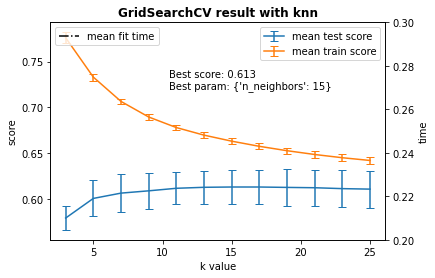

In [17]:
# Plotting score of knn depending on k
best_test_score = max(res['mean_test_score'])
fig, ax1 = plt.subplots(1)
ax1.errorbar(list(res['param_n_neighbors']), res['mean_test_score'],
             yerr=2*res['std_test_score'], lw=1.5, capsize = 4,
             label='mean test score')
ax1.errorbar(list(res['param_n_neighbors']), res['mean_train_score'],
             yerr=2*res['std_train_score'], lw=1.5, capsize = 4,
             label='mean train score')
ax2 = ax1.twinx()
ax2.plot(list(res['param_n_neighbors']), res['mean_fit_time'],
             label='mean fit time', c='k', lw=1.5, ls='-.')
ax1.set_ylabel('score'), ax2.set_ylabel('time')
ax1.set_xlabel('k value')
ax2.set(ylim=(0.2,0.3))
ax1.legend(loc=1), ax2.legend(loc=2)
plt.title('GridSearchCV result with knn',
          fontweight='bold', fontsize=12)
fig.text(0.4,0.65,'Best score: {:.3f}'.format(best_test_score)+\
               '\nBest param: '+str(gsCV.best_params_))
plt.show()

In [18]:
## Predicting test set with the model
y_pr = gsCV.predict(X_sc_te)
# checking predictions <0
print((y_pr<0).sum())

0


In [0]:
## Assessing perf of the model
def reg_metrics(yte, ypr):
    MAE = metrics.mean_absolute_error(yte, ypr)
    MSE = metrics.mean_squared_error(yte, ypr)
    RMSE = np.sqrt(MSE)
    RSE = ((ypr - yte) ** 2).sum()/((yte - yte.mean()) ** 2).sum()
    R2 = metrics.r2_score(yte, ypr)
    with np.printoptions(precision=3, suppress=True):
        print("MAE, MSE, RMSE, RSE, R2\n", np.array([MAE, MSE, RMSE, RSE, R2]))

In [20]:
## Comparison with naïve baselines
# Knn model
print('--- knn model')
reg_metrics(y_te, y_pr)
# normal random distribution
print('--- normal random distribution')
y_pr_rand = np.random.normal(0,1, y_pr.shape)
reg_metrics(y_te, y_pr_rand)
# dummy regressors
for s in ['mean', 'median']:
    print('--- dummy regressor: '+s)
    dum = DummyRegressor(strategy=s).fit(X_sc_tr, y_tr)
    y_pr_dum = dum.predict(X_sc_te)
    reg_metrics(y_te, y_pr_dum)

--- knn model
MAE, MSE, RMSE, RSE, R2
 [1.117 5.957 2.441 0.354 0.646]
--- normal random distribution
MAE, MSE, RMSE, RSE, R2
 [ 3.035 25.217  5.022  1.5   -0.5  ]
--- dummy regressor: mean
MAE, MSE, RMSE, RSE, R2
 [ 2.636 16.816  4.101  1.    -0.   ]
--- dummy regressor: median
MAE, MSE, RMSE, RSE, R2
 [ 2.431 18.304  4.278  1.088 -0.088]


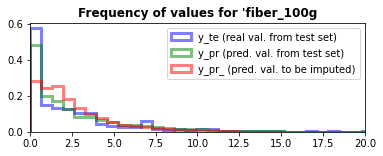

In [21]:
## Imputation using knn predictions
# Predicting missing values in 'fiber_100g'
df_miss = df.loc[df['fiber_100g'].isna(), vars_knn]
data = df_miss.values
X_sc = StandardScaler().fit_transform(data)
y_pr_ = gsCV.predict(X_sc)
# Plotting dispersion of data to be imputed
bins = plt.hist(y_te, alpha=0.5, color='b', bins=150, density=True,
                histtype='step', lw=3, label='y_te (real val. from test set)')[1]
ax=plt.gca()
ax.hist(y_pr, alpha=0.5,color='g', bins=bins, density=True,
        histtype='step', lw=3, label='y_pr (pred. val. from test set)');
ax.hist(y_pr_, alpha=0.5, color='r', bins=bins, density=True,
        histtype='step', lw=3, label='y_pr_ (pred. val. to be imputed)');
ax.set(xlim=(0,20))
ax.legend(loc=1)
plt.title("Frequency of values for 'fiber_100g",
          fontweight='bold', fontsize=12)
plt.gcf().set_size_inches(6,2)
plt.show()
# Imputing values
df.loc[df_miss.index, 'fiber_100g'] = y_pr_

In [22]:
speak('imputation case 2 quantitative: done')

col_2_C : ['nova_group', 'pnns1', 'pnns2', 'main_category']

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier

Let's try to infer 'main_category' (2_C) from 'categories_main' (1_C)

total nb of notna rows available to train the model: 530486
original 'categories_main':  186 unique values.
subset of 'categories_main':  29 unique values.


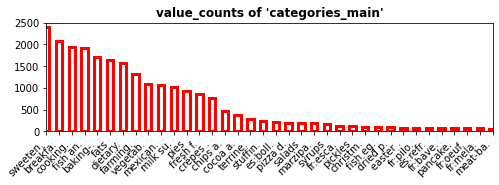

remaining notna rows available to train the model: 530486


Index(['categories_main', 'main_category'], dtype='object')

In [30]:
## Data Preprocessing

# -- Selecting most correlated features (see ppscore matrix below)
cat_to_impute = 'main_category'
vars_knn = ['categories_main']
# ---- data with no nan
# n_sample = 
df_tr = df[vars_knn+[cat_to_impute]].dropna(how='any')
print('total nb of notna rows available to train the model:', df_tr.shape[0])
# df_tr = df_tr.sample(n_sample)
# print('selection of rows to train the model:', df_knn.shape[0])

# -- Keeping only a subset with less unique values
# ---- creating the subset
n_uni_thresh = 500
print("original 'categories_main': ", str(df_tr['categories_main'].nunique()), "unique values.")
cat_occ = df_tr['categories_main'].value_counts()
to_keep = cat_occ[cat_occ>n_uni_thresh].index
sub_ser = df_tr['categories_main'].where(df['categories_main'].isin(to_keep))
print("subset of 'categories_main': ", str(sub_ser.nunique()), "unique values.")
# ---- visualizing to choose a threshold of unique values
cat_occ.plot.bar(color='None', ec='r', lw=3)
ax = plt.gca()
ax.set(xlim=(15,50), ylim=(0,2500))
ax.set_title("value_counts of 'categories_main'", fontweight='bold')
labels = [item.get_text() for item in ax.get_xticklabels()]
short_labels = [s[0:7]+'.' if len(s)>7 else s for s in labels]
ax.axes.set_xticklabels(short_labels)
plt.xticks(rotation=45, ha='right')
plt.gcf().set_size_inches(8,2)
plt.show()
df_tr_sel = df_tr.loc[sub_ser.index]
print('remaining notna rows available to train the model:', df_tr_sel.shape[0])

# Encoding dependant variables to dummy variables
df_X_enc = pd.get_dummies(df_tr_sel[vars_knn])
# ---> X to fit the model
X = df_X_enc.values[:,:-1] # excluding 1 dummy to avoid multicolinearity
# ---> X where y missing rows
ind_to_impute = df.loc[df[cat_to_impute].isna()].index
############ A REGLER ###############
# X_ = df_X_enc.loc[ind_to_impute,vars_knn].values
# print('X shape (train): ', X.shape)
# print('X_ shape (to impute): ', X_.shape)
# le = LabelEncoder()
# y = le.fit_transform(df_knn.iloc[:,-1].values)
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

In [0]:
# Importing existing model
# gsCV, res = joblib.load('My Drive/--DATA SCIENCE/PROJET3/gsCV_res_C2.pkl')
# gsCV, res = joblib.load('/content/gsCV_res_C2.pkl')

In [0]:
# ## Creating and training knn classifier
# skf = StratifiedKFold(n_splits=5, shuffle=True)
# gsCV = GridSearchCV(KNeighborsClassifier(),
#                     {'n_neighbors': [7,9,11,13]},
#                     cv=skf, return_train_score=True,
#                     scoring='accuracy')
# gsCV.fit(X_tr, y_tr)
# res = gsCV.cv_results_
# print(str(gsCV.best_params_), max(res['mean_test_score']))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [0]:
# # exporting the model
# joblib.dump((gsCV, res),'/content/gsCV_res_C2.pkl');

In [0]:
# ## Predicting test set with the model
# y_pr = gsCV.predict(X_te)
# ## Comparison of accuracy with naïve baselines
# # Knn model
# print('--- knn model')
# print('accuracy: ', metrics.accuracy_score(y_te, y_pr))
# # dummy classifier
# for s in ['stratified','most_frequent','uniform']:
#     print('--- dummy classifier: '+s)
#     dum = DummyClassifier(strategy=s).fit(X_tr, y_tr)
#     y_pr_dum = dum.predict(X_te)
#     print('accuracy: ', metrics.accuracy_score(y_te, y_pr_dum))
#     '''--- knn model
# accuracy:  0.2065
# --- dummy classifier: stratified
# accuracy:  0.0115
# --- dummy classifier: most_frequent
# accuracy:  0.0675
# --- dummy classifier: uniform
# accuracy:  0.0005'''

In [0]:
# ## Imputation using knn predictions
# # Predicting missing values in 'main_category'
# y_pr_ = gsCV.predict(X_)
# y_pr_class = le.inverse_transform(y_pr_)
# print(y_pr_class, len(y_pr_class))

In [0]:
# # Plotting bar plots of data to be imputed
# ser_pred = pd.Series(y_pr_class).value_counts()/len(y_pr_class)
# ser_known = pd.Series(le.inverse_transform(y)).value_counts()/len(y)
# ser_known_sel = ser_known[ser_known.index.isin(ser_pred.index.unique())]
# ser_known_sel_sorted = pd.Series([ser_known_sel.loc[s] for s in ser_pred.index], index=ser_pred.index)
# ser_known_sel_sorted.plot.bar(color='None', ec='b', lw=3,
#                               label='freq in training set', zorder=10)
# ax = plt.gca()
# ser_pred.plot.bar(color='None', ec='r', lw=3, ax=ax,
#                   label='freq in predicted values', zorder=3)
# ax.set_title('data to be imputed', fontweight='bold')
# labels = [item.get_text() for item in ax.get_xticklabels()]
# short_labels = [s[0:7]+'.' if len(s)>7 else s for s in labels]
# ax.axes.set_xticklabels(short_labels)
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# ax.legend(loc=1)
# plt.title("Frequency of values in 'main_category'",
#           fontweight='bold', fontsize=12)
# plt.gcf().set_size_inches(6,2)
# # plt.savefig('histo_cat.png', dpi=400)
# # plt.show()

In [0]:
# # Imputing values
# df.loc[ind_to_impute, 'main_category'] = y_pr_class

In [0]:
### Restent à faire :
'''
retirer les valeurs les moins fréquentes de 'categories_main'
imputation main_category(categories_main)
imputation pnns2(main_category),
imputation pnns1(pnns2),
imputation nova_group(pnns2, others ?)
'''

In [0]:
speak('imputation case 2 qualitative done')

#### Case 3: missing data can be infered with 0 (optional data)

In [0]:
# Case 3 : imputation with 0
for c in cols_3_Q:
    df[c] = df[c].fillna(0)
for c in cols_3_C:
    df[c] = df[c].fillna('None')
for c in cols_3_C_:
    df[c] = df[c].fillna(('None'))

In [0]:
speak('imputation case 3 qualitative done')

## 1 Univariate analysis

### 1.1 Quantitative data

#### Histograms

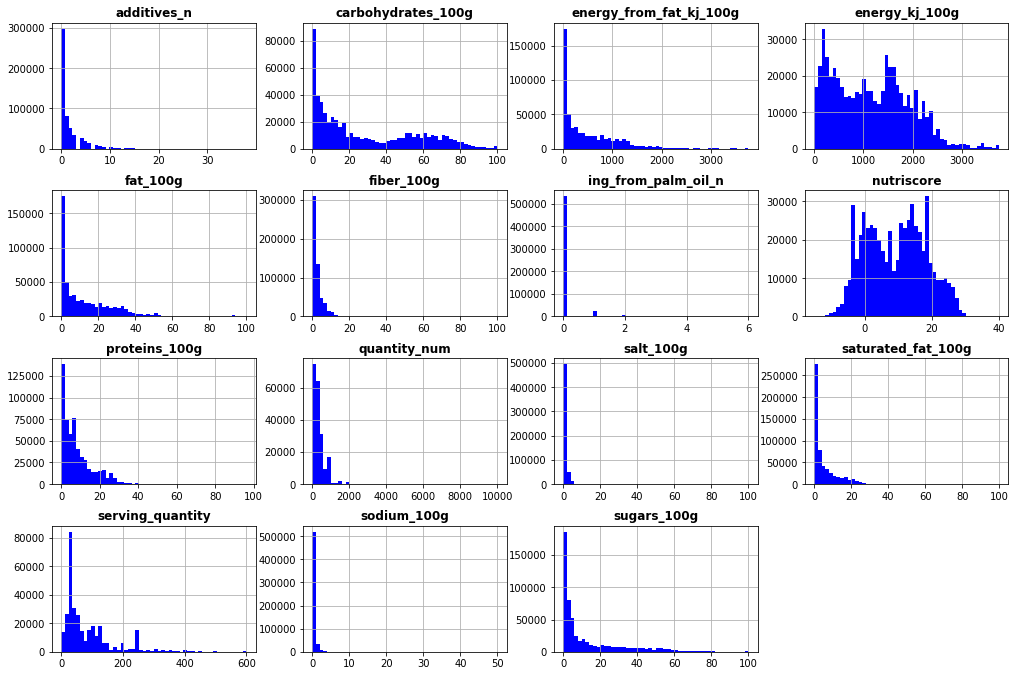

In [84]:
# Plotting histograms of the main quantitative continuous columns
quant_cols = cols_1_Q + cols_2_Q + cols_3_Q + cols_4_Q
# fig = plt.figure(figsize=(14,10))
fig = df[quant_cols].hist(figsize=(18,6), bins=50, color='b',
                        xlabelsize=10, ylabelsize=10);
[x.title.set_fontweight('bold') for x in fig.ravel()];
plt.tight_layout(w_pad=1, h_pad=-0.8)
plt.gcf().set_size_inches(14,10)
#plt.savefig('histo_quant.png', dpi=400)
plt.show()

#### Normality test

Let's test normality of the distribution of our quantitative data

In [0]:
quant_cols = cols_1_Q + cols_2_Q + cols_3_Q + cols_4_Q

In [153]:
data = df['serving_quantity']
data_notna = data[data.notna()]
data.shape, data_notna.shape

((563352,), (323858,))

In [0]:
# Normality Tests
from scipy.stats import shapiro, normaltest, anderson

def normality_tests(data, print_opt=False):
    df_res = pd.DataFrame([])
    data_notna = data[data.notna()]
    # Shapiro-Wilk - D'Agostino's K^2
    for f_name, func in zip(['Shapiro-Wilk', "D'Agostino K^2"],[shapiro, normaltest]):
        stat, p = func(data_notna)
        df_res.loc[f_name,'stat'] = stat
        df_res.loc[f_name,'p_value'] = p
        if print_opt: print('---'+f_name) 
        if print_opt: print('stat=%.3f, p=%.3f' % (stat, p))
        df_res.loc[f_name,'res'] = [p > 0.05]
        if p > 0.05:
            if print_opt: print('Probably Gaussian')
        else:
            if print_opt: print('Probably not Gaussian')
    # Anderson-Darling
    result = anderson(data_notna)
    if print_opt: print('---'+'Anderson-Darling')
    df_res.loc['Anderson-Darling','stat'] = result.statistic
    if print_opt: print('stat=%.3f' % (result.statistic))
    res_and = [(int(result.significance_level[i]),result.statistic < res)\
                   for i,res in enumerate(result.critical_values)]
    df_res.loc['Anderson-Darling','res'] = str(res_and)
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            if print_opt: print('Probably Gaussian at the %.1f%% level' % (sl))
        else:
            if print_opt: print('Probably not Gaussian at the %.1f%% level' % (sl))
    return df_res

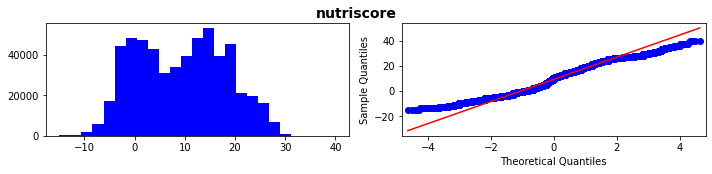

nutriscore


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.976589,0.0,False
D'Agostino K^2,105748.776217,0.0,False
Anderson-Darling,4972.620164,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


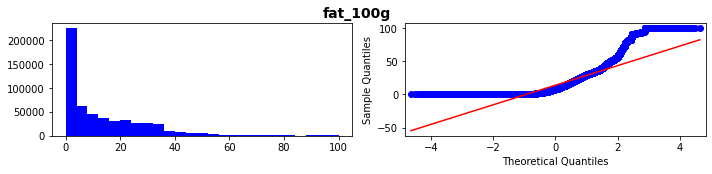

fat_100g


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.793252,0.0,False
D'Agostino K^2,214476.465208,0.0,False
Anderson-Darling,31076.148909,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


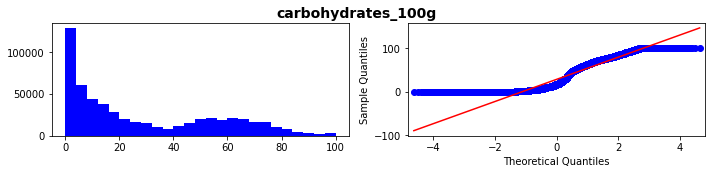

carbohydrates_100g


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.872853,0.0,False
D'Agostino K^2,114641.276789,0.0,False
Anderson-Darling,27065.379791,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


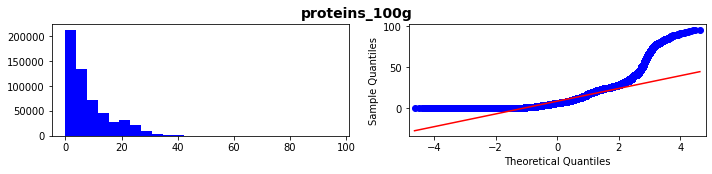

proteins_100g


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.822735,0.0,False
D'Agostino K^2,256377.322653,0.0,False
Anderson-Darling,23812.657330,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


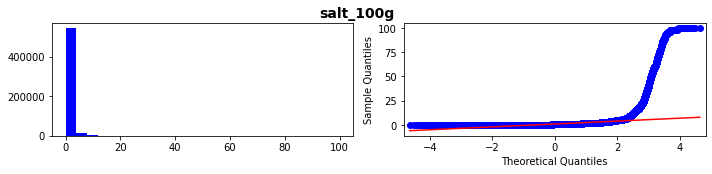

salt_100g


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,2.355524e-01,0.0,False
D'Agostino K^2,1.160457e+06,0.0,False
Anderson-Darling,1.018753e+05,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


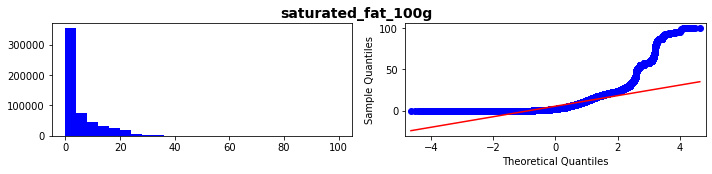

saturated_fat_100g


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.691519,0.0,False
D'Agostino K^2,382543.608174,0.0,False
Anderson-Darling,48804.482028,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


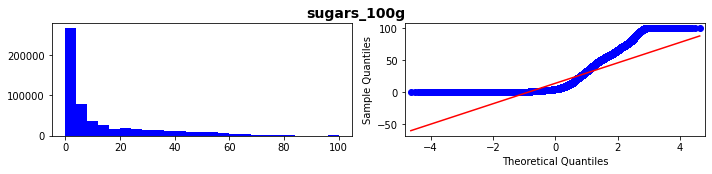

sugars_100g


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.735203,0.0,False
D'Agostino K^2,184962.710557,0.0,False
Anderson-Darling,55488.853213,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


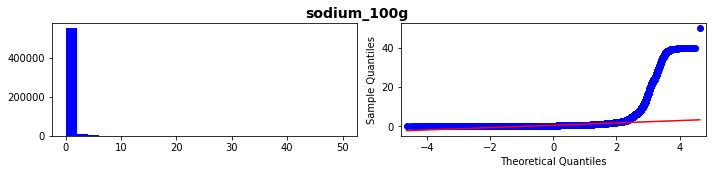

sodium_100g


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,2.351056e-01,0.0,False
D'Agostino K^2,1.161691e+06,0.0,False
Anderson-Darling,1.019825e+05,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


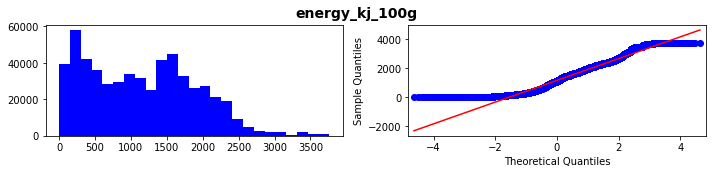

energy_kj_100g


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.959423,0.0,False
D'Agostino K^2,25235.198981,0.0,False
Anderson-Darling,5857.162631,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


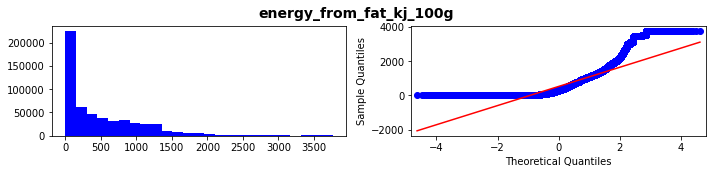

energy_from_fat_kj_100g


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.793252,0.0,False
D'Agostino K^2,214476.464547,0.0,False
Anderson-Darling,31076.148895,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


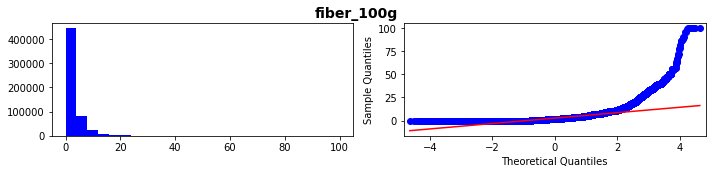

fiber_100g


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.685205,0.0,False
D'Agostino K^2,510299.197133,0.0,False
Anderson-Darling,36998.490576,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


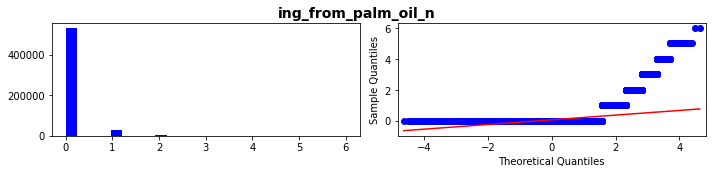

ing_from_palm_oil_n


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.231118,0.0,False
D'Agostino K^2,611530.074606,0.0,False
Anderson-Darling,192039.131391,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


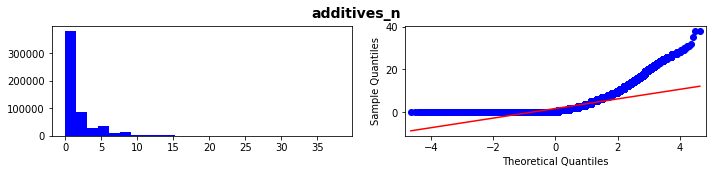

additives_n


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,stat,p_value,res
Shapiro-Wilk,0.654751,0.0,False
D'Agostino K^2,325411.497709,0.0,False
Anderson-Darling,64697.559330,NaN,"[(15, False), (10, False), (5, False), (2, Fal..."


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


RuntimeError: ignored

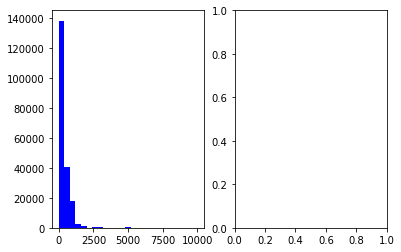

In [155]:
# Plotting histograms and qqplots of the main quantitative continuous columns
from statsmodels.graphics.gofplots import qqplot

def plot_hist_qqplot(data, name):
    fig, axs = plt.subplots(1,2)
    # histogram
    axs[0].hist(data, color='b', bins =25);
    # with statsmodels qqplot's module
    qqplot(data, line='r', ax=axs[1])
    plt.gcf().set_size_inches(10,2.5)
    fig.suptitle(name, fontweight='bold', size=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plotting QQplots and normality tests stats
for i, c in enumerate(quant_cols,1):
    plot_hist_qqplot(df[c].values, c)
    print(c)
    display(normality_tests(df[c], print_opt=False))
    ax.set_title(c, fontweight='bold')
#plt.savefig('qqplots.png', dpi=400)

### 1.2 Qualitative data

In [0]:
qual_cols = cols_1_C + cols_2_C + cols_3_C + cols_4_C

#### Bar plots

In [0]:
# Plotting bar plots of the main categorical columns
fig = plt.figure(figsize=(14,10))
for i, c in enumerate(qual_cols,1):
    ax = fig.add_subplot(4,4,i)
    ser = df[c].value_counts()
    if ser.shape[0]>15:
        ser[0:15].plot.bar(color='b',ax=ax)
    else:
        ser.plot.bar(color='b',ax=ax)
    ax.set_title(c, fontweight='bold')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [s[0:7]+'.' if len(s)>7 else s for s in labels]
    ax.axes.set_xticklabels(short_labels)
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig('histo_cat.png', dpi=400)
plt.show()

#### Distribution depending on categorical data

In [0]:
boxplot_cols = quant_cols

for nutrigrades subsets

In [0]:
# nutriscore

nutri_pal = ['#008000', '#78D222', '#FFD700', '#FF8D00' , '#F23824']

fig = plt.figure(figsize=(12,7))
with sns.color_palette(nutri_pal):
    for i, c in enumerate(boxplot_cols,1):
        ax = fig.add_subplot(3,4,i)
        sns.boxplot(data=df, x='nutrigrade', y=c, order=list('abcde'), ax=ax)
        min = df[c].mean()-3*df[c].std()
        max = df[c].mean()+3*df[c].std()
        plt.ylim(min,max)
plt.tight_layout()

for categories subsets

In [0]:
# pnns1

pnns1_pal = sns.color_palette(palette='bright')

fig = plt.figure(figsize=(15,10))
with sns.color_palette(pnns1_pal):
    for i, c in enumerate(boxplot_cols,1):
        ax = fig.add_subplot(3,4,i)
        sns.boxplot(data=df, x='pnns1', y=c, ax=ax)# order=list('abcde')
        min = df[c].mean()-3*df[c].std()
        max = df[c].mean()+3*df[c].std()
        plt.ylim(min,max)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [s[0:10]+'.' if len(s)>10 else s for s in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')
plt.tight_layout()

## 2 Bivariate analysis

### 2.0 Time analysis

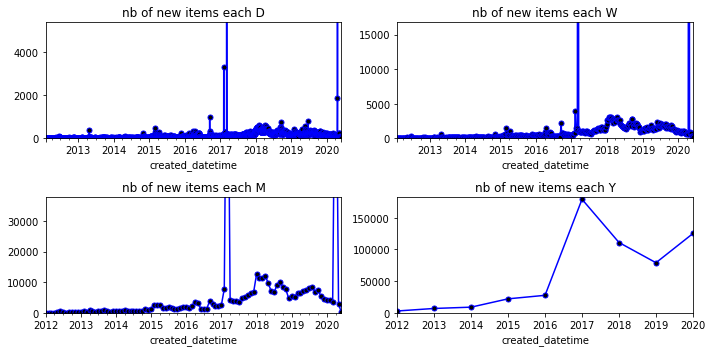

In [185]:
# Plotting number of new items through time
fig = plt.figure(figsize=(10,5))
for i,per in enumerate(['D', 'W', 'M', 'Y'],1):
    ax = fig.add_subplot(2,2,i)
    t_ser = df.groupby(pd.Grouper(key='created_datetime', freq=per)).size()
    t_ser.plot(ax=ax, ms=5, marker='o', mfc='k', color='b', ls='-')
    ax.set(ylim=(0,np.mean(t_ser)+2*np.std(t_ser)))
    ax.set_title("nb of new items each "+per)
fig.tight_layout()

### 2.1 Linear correlation

In [0]:
def plot_heatmap(corr, title, figsize=(8,4), vmin=-1, vmax=1, center=0,
                 palette = sns.color_palette("coolwarm", 20), rect=False):
    fig, ax = plt.subplots(figsize=figsize)
    if rect==True:
        mask=None
    else:
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    palette = palette
    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=True, annot_kws={"size": 10},fmt='.2f',
                     square=False, linewidths=.5, linecolor = 'white',
                     cbar_kws={"shrink": .9, 'label': None},
                     xticklabels= corr.index, yticklabels = corr.columns)
    ax.tick_params(labelsize=10,top=False, bottom=True,
                labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=12)
    plt.show()

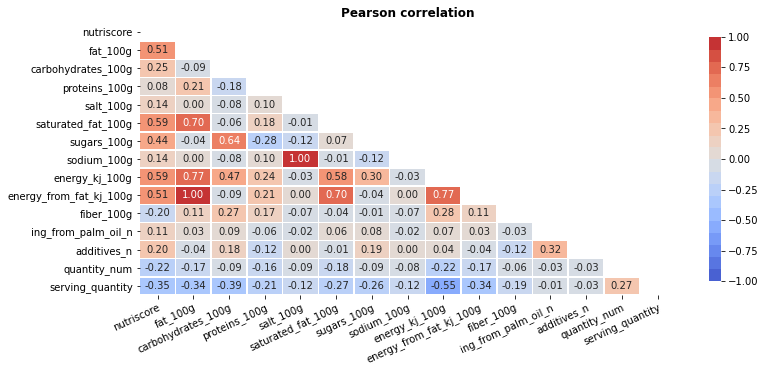

In [160]:
# Linear correlation (Pearson)
# cols = cols_1_Q+['fiber_100g']
cols = quant_cols
pears_corr = df[cols].corr()
plot_heatmap(pears_corr, rect=False, title="Pearson correlation", figsize=(12,5))

Some of the correlations are quite obvious, as for example:
- fat -> energy
- sugars -> carbohydrates
- fat, saturated, fat, sugars, energy -> nutriscore
- nutriscore -> nutrigrade
More suprisingly :
- more fibers can be found in high energy products

As we know from its formula, nutriscore:
- increases with energy, saturated fat, sugar and salt
- decreases with fibers, proteins and fruits and vegetable content

However, which is more interesting is that the value of correlation coefficient indicates that in the case of most of the actual products, the main factors that are correlated with nutriscore are (decreasing order):
- fat, energy, saturated fat, carbohydrates, sugar
- whereas sodium is very weakly correlated to a high nutriscore.

__=> Food industry should focus primarily on decreasing fat to lower the nutriscore of their products__.


### 2.2 Correlation tests

In [0]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def correlation_tests(data1, data2, print_opt=False):
    df_res = pd.DataFrame([])
    # data1_notna = data1[data1.notna()]
    # Pearson, Spearman, Kendall
    for f_name, func in zip(['Pearson', 'Spearman', 'Kendall'],[pearsonr, spearmanr, kendalltau]):
        stat, p = func(data1, data2)
        df_res.loc[f_name,'stat'] = stat
        df_res.loc[f_name,'p_value'] = p
        if print_opt: print('---'+f_name)
        if print_opt: print('stat=%.3f, p=%.3f' % (stat, p))
        if print_opt:print('Probably independent') if p > 0.05 else print('Probably dependent')
    return df_res

In [176]:
# Correlation test
display(correlation_tests(df['fat_100g'], df['nutriscore'], print_opt=False))
display(correlation_tests(df['carbohydrates_100g'], df['nutriscore'], print_opt=False))
display(correlation_tests(df['energy_kj_100g'], df['nutriscore'], print_opt=False))
display(correlation_tests(df['fat_100g'], df['energy_kj_100g'], print_opt=False))

# for i, c in enumerate(quant_cols,1):
#     print(c)
#     display(correlation_tests(data1, data2, print_opt=False))
#     ax.set_title(c, fontweight='bold')
#plt.savefig('qqplots.png', dpi=400)

,stat,p_value
Pearson,0.506213,0.0
Spearman,0.592978,0.0
Kendall,0.427387,0.0


,stat,p_value
Pearson,0.246083,0.0
Spearman,0.194244,0.0
Kendall,0.136503,0.0


,stat,p_value
Pearson,0.593203,0.0
Spearman,0.611738,0.0
Kendall,0.445450,0.0


,stat,p_value
Pearson,0.772700,0.0
Spearman,0.753724,0.0
Kendall,0.589800,0.0


### 2.3 Correlation with Predictive Power Score (decision tree based)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

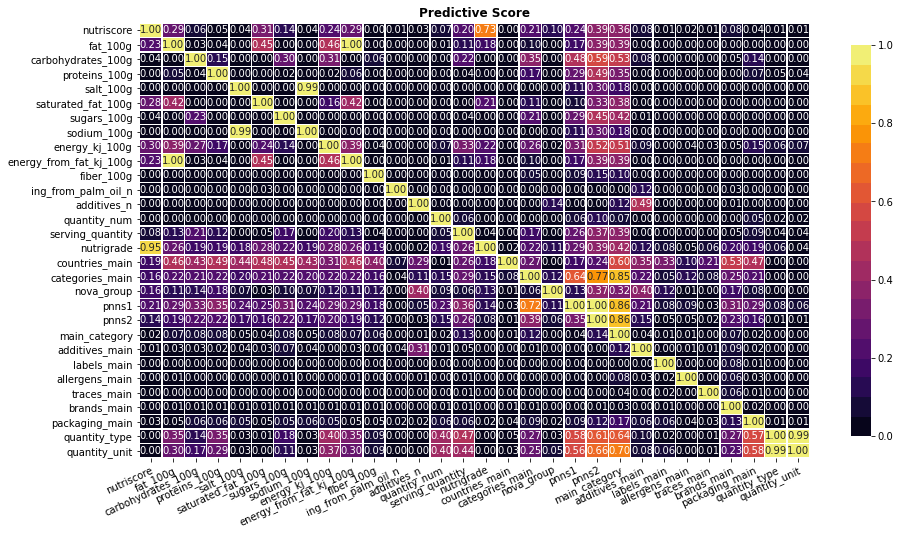

In [159]:
# Predictive Power Score (ppscore)
# pps_corr = pps.matrix(df[cols_1_Q+cols_1_C+cols_2_C+cols_2_Q])
cols = quant_cols + qual_cols
pps_corr = pps.matrix(df[cols])
plot_heatmap(pps_corr, title="Predictive Score", 
             vmin=0, center=0.5, figsize=(15,8), rect=True,
             palette=sns.color_palette("inferno", 20))

It seems that categories have a strong relation to most of the nutritional values.

countries as well seem to have a strong relationship to nutritional values. 

### 2.4 Contingency table and Chi-squared

In [0]:
# ## Creating table of contingency
# data = pd.read_csv("loan_status.csv") 
# # by hand
# display(data.pivot_table(index = 'grade',
#                          columns = 'loan_status',
#                          values='purpose',
#                          aggfunc='count').fillna(0))
# # with pandas
# data_crosstab = pd.crosstab(data['grade'], 
#                             data['loan_status'],  
#                                margins = True)
# display(data_crosstab)

In [0]:
# # Chi-Squared Test
# from scipy.stats import chi2_contingency
# stat, p, dof, expected = chi2_contingency(data_crosstab)
# print('---'+"Chi-squared")
# print('stat=%.3f, p=%.3f' % (stat, p))
# print('Probably independent') if p > 0.05 else print('Probably dependent')

### 2.5 ANOVA

In [0]:
## Test de normalité à faire dans les sous-groupes

In [187]:
# Analysis of Variance Test (ANOVA)
from scipy.stats import f_oneway
stat, p = f_oneway(data1, data2)
print('---'+" ANOVA")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')

--- ANOVA
stat=0.265, p=0.613
Probably same distribution



### 2.6 Non-parametric statistical hypothesis tests

In [0]:
# Example of the Mann-Whitney U Test
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(data1, data2)
print('---'+" U-test (Mann-Whitney)")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')

# Example of the Wilcoxon Signed-Rank Test
from scipy.stats import wilcoxon
stat, p = wilcoxon(data1, data2)
print('---'+" Signed-rank (Wilcoxon)")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')

# Example of the Kruskal-Wallis H Test
from scipy.stats import kruskal
stat, p = kruskal(data1, data2)
print('---'+" H-test (Kruskal-Wallis)")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')
    
# Example of the Friedman Test
from scipy.stats import friedmanchisquare
stat, p = friedmanchisquare(data1, data2, data3)
print('---'+" ANOVA")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably same distribution\n') if p > 0.05 else print('Probably not the same distribution\n')

### 2.7 Pair plots

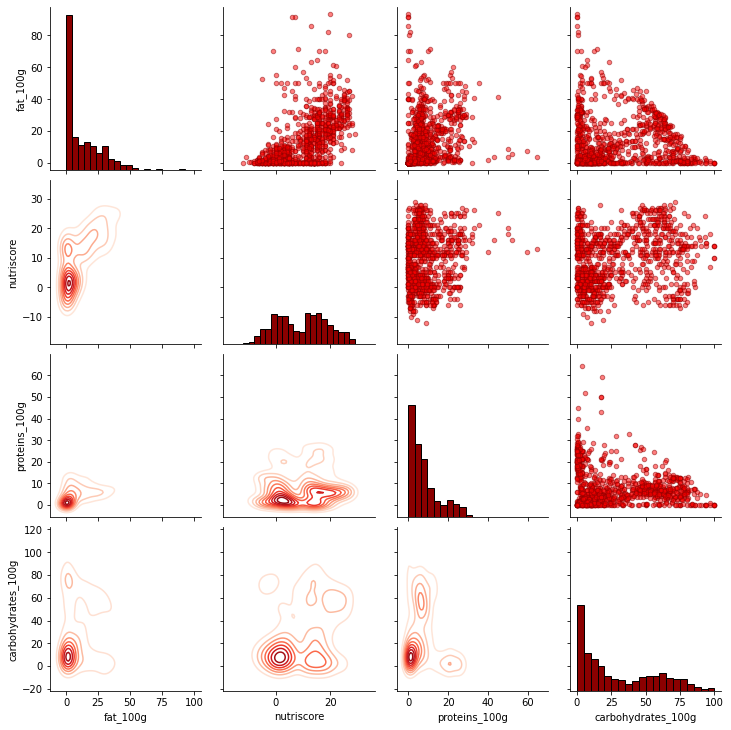

In [161]:
# Scatterplot matrix (too much data -> on a sample)
cols = ['fat_100g', 'nutriscore','proteins_100g','carbohydrates_100g']
df_sample = df.sample(1000)

grid = sns.PairGrid(data=df_sample,
                    vars=cols, height=2.5)
grid = grid.map_upper(plt.scatter, marker='o', edgecolors='darkred',
                      alpha=0.5, color='red', s=20)
# grid = grid.map_upper(testcorr)
grid = grid.map_diag(plt.hist, bins = 20, color = 'darkred', edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')

#cols = ['fat_100g', 'nutriscore','proteins_100g','carbohydrates_100g']
# 1000 => CPU times: user 9.03 s, sys: 292 ms, total: 9.32 s Wall time: 9 s
# 10000 => CPU times: user 42.9 s, sys: 318 ms, total: 43.2 s Wall time: 42.9 s
# 100000 => CPU times: user 6min 40s, sys: 3.93 s, total: 6min 44s Wall time: 6min 44s

## 3 Multivariable analysis

### 3.1 PCA (Principal Component Analysis)

In [0]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, width=16,
                    label_rotation=0, lims=None, n_cols=3):
    n_rows = (n_comp+1)//n_cols
    fig = plt.figure(figsize=(width,n_rows*width/n_cols))
    # boucle sur les plans factoriels (3 premiers plans -> 6 composantes)
    for i, (d1, d2) in enumerate(axis_ranks): 
        if d2 < n_comp:
            ax = fig.add_subplot(n_rows, n_cols, i+1)
            # limites
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])
            # flèches, si plus de 30, pas de pointes
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, alpha=.1, color='black'))
            # noms de variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        ax.text(x, y, labels[i], fontsize='14', ha='center', va='center',
                                rotation=label_rotation, color="blue", alpha=0.5)
            # cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            ax.add_artist(circle)
            # définition des limites du graphique
            ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
            # affichage des lignes horizontales et verticales
            ax.plot([-1, 1], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-1, 1], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            ax.set_title("PCA correlation circle (PC{} and PC{})".format(d1+1, d2+1))
    plt.tight_layout()
    plt.show()

In [0]:
def display_factorial_planes(X_proj, n_comp, pca, axis_ranks, labels=None,
                             width=16, alpha=1, n_cols=3, illus_var=None,
                             lab_on=True, size=10):
    n_rows = (n_comp+1)//n_cols
    fig = plt.figure(figsize=(width,n_rows*width/n_cols))
    # boucle sur chaque plan factoriel
    for i, (d1,d2) in (enumerate(axis_ranks)):
        if d2 < n_comp:
            ax = fig.add_subplot(n_rows, n_cols, i+1)
            # points
            if illus_var is None:
                ax.scatter(X_proj[:, d1], X_proj[:, d2], alpha=alpha, s=size)
            else:
                illus_var = np.array(illus_var)
                for value in np.unique(illus_var):
                    sel = np.where(illus_var == value)
                    ax.scatter(X_proj[sel, d1], X_proj[sel, d2], 
                                alpha=alpha, label=value)
                ax.legend()
            # labels points
            if labels is not None and lab_on:
                for i,(x,y) in enumerate(X_proj[:,[d1,d2]]):
                    ax.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center')   
            # limites
            bound = np.max(np.abs(X_proj[:, [d1,d2]])) * 1.1
            ax.set(xlim=(-bound,bound), ylim=(-bound,bound))
            # lignes horizontales et verticales
            ax.plot([-100, 100], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-100, 100], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            ax.set_title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
    plt.tight_layout()

In [0]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rank")
    plt.ylabel("explained variance ratio")
    plt.title("Scree plot")
    plt.show()

In [180]:
np.set_printoptions(formatter={'float': '{: 6.3f}'.format})

df_sample = df.sample(5000)

# Feature selection for PCA
id_code = df_sample.index
# pca_cols = ['fat_100g','energy_kj_100g', 
#             'sugars_100g','sodium_100g', 'ing_from_palm_oil_n', 'nutriscore']
pca_cols = ['fat_100g', 'carbohydrates_100g', 'proteins_100g',
            'saturated_fat_100g','energy_kj_100g', 'fiber_100g',
            'sugars_100g','sodium_100g', 'ing_from_palm_oil_n', 'nutriscore']

# Imputation of missing values
print('-----missing values imputation-----')
# faire une imputation par catégorie ?
display(df_sample[pca_cols].isna().sum())
X = df_sample[pca_cols].fillna(df_sample.mean()).values

# Data standardisation
print('-----standardisation-----')
X_sc = StandardScaler().fit_transform(X)
print(X_sc)

# Principal components calculation
n = 10
pca = PCA(n_components=n).fit(X_sc)
print("\n-----explained variance ratio-----")
print(pca.explained_variance_ratio_)
print('\n-----coefficients of principal components (original features)-----')
print(pca.components_)
print('\n-----data projected in new space-----')
print(pca.transform(X_sc))

-----missing values imputation-----


fat_100g               0
carbohydrates_100g     0
proteins_100g          0
saturated_fat_100g     0
energy_kj_100g         0
fiber_100g             0
sugars_100g            0
sodium_100g            0
ing_from_palm_oil_n    0
nutriscore             0
dtype: int64

-----standardisation-----
[[ 0.677 -0.594  0.966 ...  0.307 -0.225  0.991]
 [ 5.193 -1.052 -0.969 ... -0.445 -0.225  0.214]
 [-0.732 -0.499 -0.222 ... -0.202 -0.225 -1.230]
 ...
 [-0.233 -1.026  0.424 ... -0.312 -0.225 -1.119]
 [ 1.178 -0.807 -0.969 ...  0.331  2.891  0.880]
 [-0.236  0.149 -0.398 ... -0.327 -0.225  0.214]]

-----explained variance ratio-----
[ 0.311  0.195  0.138  0.102  0.097  0.068  0.037  0.026  0.021  0.004]

-----coefficients of principal components (original features)-----
[[ 0.453  0.206  0.114  0.446  0.520  0.061  0.228  0.022  0.065  0.459]
 [ 0.286 -0.572  0.392  0.239 -0.033 -0.097 -0.555  0.228 -0.095 -0.025]
 [ 0.055  0.201  0.350 -0.138  0.225  0.749 -0.158 -0.172 -0.183 -0.340]
 [-0.218  0.235  0.249 -0.208  0.019  0.022  0.103  0.833 -0.242  0.168]
 [-0.048  0.043  0.129 -0.090  0.010  0.150 -0.119  0.205  0.944 -0.032]
 [ 0.302 -0.061 -0.773  0.048  0.060  0.315 -0.199  0.375 -0.033 -0.149]
 [-0.280 -0.342  0.009  0.460 -0.415  0.498  0.360  0.049  0

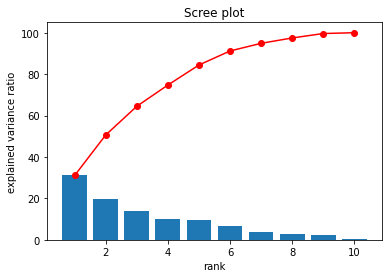

In [181]:
# Eboulis des valeurs propres
display_scree_plot(pca)

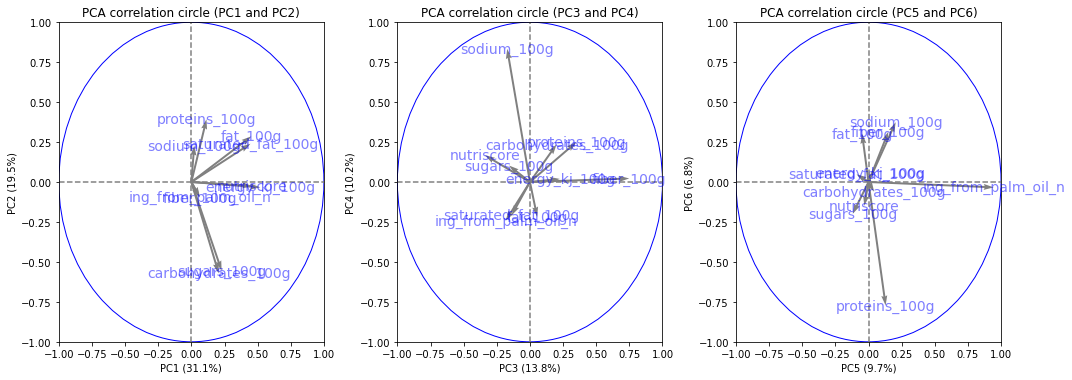

In [182]:
# Cercle des corrélations
display_circles(pca.components_, n, pca, [(0,1),(2,3),(4,5)],
                labels = np.array(pca_cols), width=15,  n_cols=3)

In [0]:
# # Projection des individus sur les plans d'origine
# fig = plt.figure(figsize=(16,6))
# for i, (d1,d2) in (enumerate([(0,1),(2,3),(4,5),(6,7),(8,9)])):
#     ax = fig.add_subplot (1, 5, i+1)
#     ax.scatter(X_sc[:, d1], X_sc[:, d2], alpha=0.5, s=10)

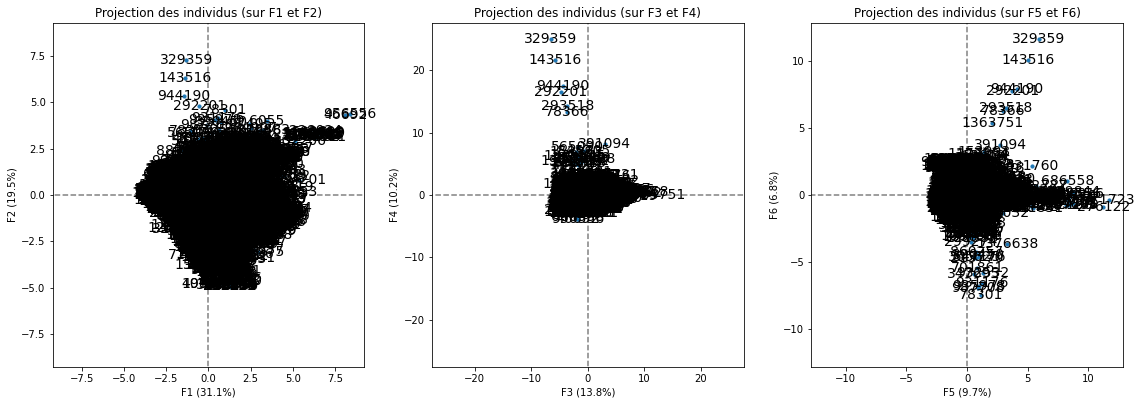

In [183]:
# Projection des individus sur le plan factoriel
display_factorial_planes(pca.transform(X_sc), n, pca, [(0,1),(2,3),(4,5)],
                         n_cols=3, labels=np.array(id_code), lab_on=True)

Using mlxtend

In [0]:
# import mlxtend
from mlxtend import plotting

In [0]:
from mlxtend.data import iris_data
import mlxtend as ml
ml.data.
# figure, correlation_matrix = plotting.plot_pca_correlation_graph(X_sc, cols,
#                                                         dimensions=(1, 2),
#                                                         figure_axis_size=10)#, X_pca, explained_variance)

### 3.2 Clustering

KMeans 

In [0]:
# df = pd.read_csv('./Dataset 1/my_courses.csv', index_col=0)
# print(df.shape[0])
# X = df.fillna(df.mean()).values
# X_sc = StandardScaler().fit_transform(X)

In [0]:
# n_clust = 6
# km = KMeans(n_clusters=n_clust).fit(X_sc)

In [0]:
# # Récupération des clusters attribués à chaque individu
# clustK = km.labels_
# df['cluster_Kmeans'] = clustK
# clustK

In [0]:
# # Projection des individus sur le plan factoriel
# pca = PCA(n_components=4).fit(X_sc)
# X_proj = pca.transform(X_sc)
# display_factorial_planes(X_proj, 4, pca,
#                          [(0,1),(2,3),(4,5)], labels=np.array(df.index),
#                          illus_var = clust.astype(np.float), alpha=0.3, n_cols=3, lab_on=False, size=10)

In [0]:
# # Affichage des clusters
# for n, s_df in df.groupby('cluster_Kmeans'):
#     display(s_df)

Hierarchical clustering

In [0]:
# # Clustering hiérarchique
# Z = linkage(X_sc, 'ward')
# Z[0:15]

In [0]:
# plt.figure(figsize=(16,10))
# dendrogram(Z, labels = df.index, orientation = "right", count_sort='descending')
# plt.show()

In [0]:
# # Coupage du dendrogramme
# n_clust = 6
# clustH = fcluster(Z, n_clust, criterion='maxclust')
# df['cluster_HierClust'] = clustH
# clustH

In [0]:
# # Affichage des clusters
# for n, s_df in df.groupby('cluster_HierClust'):
#     display(s_df)